Last updated as at 19 July 2017

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Multi-class Classification with Logistic Regression

For this first part of the exercise, we will use logistic regression to recognize ten handwritten digits (from 0 to 9). 

## Reading in and Visualizing the Data

Reading in the given MATLAB file which contains 5000 training examples of handwritten digits taken from the MNIST handwritten digit dataset. According to the assignment documentation, take note that the `0` digit is given the label `10`. 

In [2]:
import scipy.io as sio

data = sio.loadmat("./ex3data1.mat")
# X is a 5000x400 matrix holding the information for all the handwritten digits
X = data["X"]
# y is a 5000 element vector holding the class label for each digit
# We flatten y to make multiplication with the X matrix easier later on
y = data["y"].flatten()

#### Approach to visualizing a digit from an array of values

Each digit is an image size `20` by `20` pixels, where each pixel's intensity is represented by a floating point number. In constructing the `X` matrix, each digit's image was flattened into a `400` element vector and stored as a row in `X`.

The logic behind reconstructing a digit's image is therefore:

1. Index out a row vector from `X`. 
2. Reshape that vector into a `20` by `20` matrix.
3. Transpose the matrix to obtain the image in the correct orientation.

Step (3) is necessary because MATLAB flattens arrays in [column-major order](https://en.wikipedia.org/wiki/Row-_and_column-major_order). When reshapinag the image array (originally flattened in MATLAB), using `numpy`, `numpy` would reconstruct the 2D array in row-major order, so without a tranposition, the images would be flipped along the diagonal. I was reminded of this when an initial visualization of the images did not appear right, but was fixed after a transpose.

#### Visualization code notes

Next, I include some explanations interleaved with the implementation code used to generate the same image as Figure 1 in ex3.pdf. I found this general [Matplotlib tutorial](https://github.com/WeatherGod/AnatomyOfMatplotlib) and [Image tutorial](https://matplotlib.org/users/image_tutorial.html) helpful.

First, construct a figure of size 8x8 inches, that has 100 subplots, with 10 subplots in the vertical direction, and 10 subplots in the horizontal direction. Each subplot will be an image of a digit

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=10, ncols=10, figsize = (8,8))

`axes` is a `10` by `10` `numpy` array of `Axes` (synonymously called `Subplot`) objects. Using a double `for` loop, I iteratively populate the figure `fig` with images of the digits rendered using the `imshow()` method of the `plt` object. 

In each iteration:

- A digit is randomly chosen by randomly indexing a row vector from `X`.


- An `Axes` object is selected from `axes` array and the row vector is reshaped, transposed and passed to `imshow()` called on the `Axes` object. The additional argument `cmap="Greys_r"` makes the digits white against a black background. 


- The number markings on the x and y axes are then removed as it is images that we are visualizing. 

In [4]:
for i in range(0,10):
    for j in range(0,10):
        row = np.random.randint(low=0, high =5000)
        axes[i][j].imshow(X[row,:].reshape(20,20).T, cmap="Greys_r")
        # This could have also been accomplished with two separate lines:
        # axes[i][j].xticks=[] and axes[i][j].yticks=[]
        axes[i][j].set(xticks=[], yticks=[])

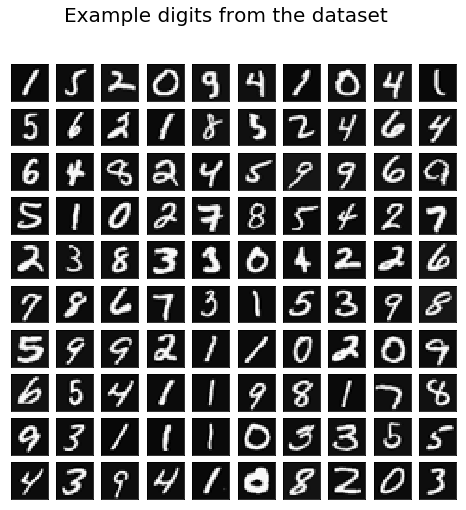

In [5]:
fig.suptitle("Example digits from the dataset", fontsize = 20)
fig

## Regularized Logistic Regression in Vectorized Form

The following functions are the same as what were implemented for Programming Exercise 2.

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
def compute_cost_regularized(theta, X, y, lda):
    reg =lda/(2*len(y)) * np.sum(theta[1:]**2) 
    return 1/len(y) * ( -y @ np.log(sigmoid(X@theta)) - (1-y) @ np.log(1-sigmoid(X@theta)) ) + reg

In [8]:
def compute_gradient_regularized(theta, X, y, lda):
    gradient = np.zeros(len(theta))
    XT = X.T
    beta = sigmoid(X@theta) - y
    regterm = lda/len(y) * theta
    # theta_0 does not get regularized, so a 0 is substituted in its place
    regterm[0] = 0 
    gradient = (1/len(y) * XT@beta).T + regterm
    return gradient

Initialize a few test arrays.

In [9]:
theta_test = np.array([-2,-1,1,2])
X_test = np.concatenate((np.ones((5,1)), 
            np.fromiter((x/10 for x in range(1,16)), float).reshape((3,5)).T), 
                        axis =1)
y_test = np.array([1,0,1,0,1])
lambda_test = 3

#### Check correctness on test inputs

The function outputs match the expected values, and pass the test. See [stackoverflow](https://stackoverflow.com/questions/44753116/coursera-ml-implementing-regularized-logistic-regression-cost-function-in-pyth) for some mistakes that had to be overcome.

In [10]:
compute_cost_regularized(theta_test, X_test, y_test,lambda_test)

2.5348193961097438

In [11]:
compute_gradient_regularized(theta_test,X_test,y_test,lambda_test)

array([ 0.14656137, -0.54855841,  0.72472227,  1.39800296])

## One-vs-all Classification with Logistic Regression

As usual, we set up the model/design matrix, `X_bias` by inserting a column of ones to accomodate the bias term $\theta_0$ in our model.

In [12]:
X_bias = np.concatenate((np.ones(X.shape[0]).reshape(X.shape[0],1),X),axis = 1)
print(X_bias.shape)
X_bias[0:3]

(5000, 401)


array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

#### train_one_vs_all() implementation notes

We initialize a matrix of zeros, `theta_all`, which holds all the trained parameters. Each row `theta_all` represents a class and the columns of `theta_all` represent all the parameters $\theta_0 \dots \theta_n$ associated with predictions for that class.

One-vs-all classification is implemented by iteratively training the parameters for each class `k`. In each iteration, the use of the `grdtruth` vector ensures all instances of `k` in our training dataset are given the label `1`, while all other instances that are not `k` are given the label `0`. This is the essence of the one-vs-all method.

Choice of optimization algorithm used is specified through a string following the choices supported by [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.minimize.html).

The `grdtruth` vector for each iteration is passed into the optimization routine as the vector of class labels. The `theta_all` array is indexed row by row in each iteration to first pass a vector of `0` (as the parameters are first initialized to zeros) into the optimization routine, and the trained parameters then being stored directly in that same row, overwriting the old zeros in place.

Regularization parameter $\lambda$ is kept at a constant value of `0.1` through all iterations.

The matrix of trained parameters is returned at the end of training.

In [13]:
def train_one_vs_all(X, y, opt_method):
    theta_all = np.zeros((y.max()-y.min()+1, X.shape[1]))
    for k in range(y.min(),y.max()+1):
        grdtruth = np.where(y==k, 1,0)
        results = minimize(compute_cost_regularized, theta_all[k-1,:], 
                           args = (X,grdtruth,0.1),
                           method = opt_method, 
                           jac = compute_gradient_regularized)
        # optimized parameters are accessible through the x attribute
        theta_optimized = results.x
        # Assign thetheta_optimized vector to the appropriate row in the 
        # theta_all matrix
        theta_all[k-1,:] = theta_optimized
    return theta_all

We train two models using two different optimization algorithms and will observe later that the choice of the optimization algorithm does have a significant affect the accuracy results.

In [14]:
theta_all_optimized_cg = train_one_vs_all(X_bias, y, 'CG')  # Optimization performed using Conjugate Gradient
theta_all_optimized_bfgs = train_one_vs_all(X_bias, y, 'BFGS') # optimization performed using Broyden–Fletcher–Goldfarb–Shanno

## One-vs-all Prediction 

We now use our trained classifiers to predict the digit contained in a given image.

#### `predict_one_vs_all()` implementation notes

We can vectorize the prediction computation after a transpose of the matrix containining all of our trained parameters for every class $\theta_0, \theta_1 \dots \theta_9$, called `theta_all`. We can then multiply the design/model matrix, `X_bias` with `theta_all`, and apply the `sigmoid()` function to every element. 

Each row of the resulting matrix will represent the probability values associated with each class for each image in our training dataset. The class whose prediction has the highest probability value will be the class that this image is predicted to belong to. Taking `np.argmax` along `axis=1` ensures that the index position of the largest probability value for each row (and hence each image) is returned.

Lastly, adding one to the resulting indices will give us the predicted class, by ensuring that we match the MATLAB/Octave convention where indexing begins at 1 and being consistent with class labels ranging from `1` to `10` as in the provided global ground truth vector `y`.

In [15]:
def predict_one_vs_all(X, theta):
    return np.mean(np.argmax(sigmoid(X@theta.T), axis=1)+1 == y)*100

### Difference in accuracy due to different optimization algorithms

We observe that the model trained with conjugate gradient performs more poorly compared to the one trained with Broyden–Fletcher–Goldfarb–Shannon (BFGS). 

According to the assignment, the accuracy of our classifier should be $94.9\%$ so the Conjugate Gradient-based model is below expectations, while the Broyden–Fletcher–Goldfarb–Shannon-based model exceeds expectations.

In [16]:
predict_one_vs_all(X_bias, theta_all_optimized_cg)

90.319999999999993

In [17]:
predict_one_vs_all(X_bias, theta_all_optimized_bfgs)

96.480000000000004

#### Conjugate Gradient does not converge as well as BFGS

The likely reason for the discrepancy is that the conjugate gradient algorithm failed to converge as close to the global minimum as BFGS did.

To verify this, we further optimize the parameters from `theta_all_optimized_cg`, which were initially obtained only through conjugate gradient. The parameters from `theta_all_optimized_cg` are copied into in a new parameter vector called `theta_all_optimized_bfgs_from_cg` which is passed into the `scipy.optimize.minimize` routine again, but using BFGS. 

The prediction accuracy using `theta_all_optimized_bfgs_from_cg` is improved from that obtained purely from conjugate gradient, and is much closer to that obtained through BFGS.

This shows that BFGS is able to further optimize the parameters that were trained from conjugate gradient, implying that BFGS converges better than conjugate gradient in this case.

See this [post](https://datascience.stackexchange.com/questions/20170/coursera-ml-does-the-choice-of-optimization-algorithm-affect-the-accuracy-of-m) on Data Science Stackexchange for a discussion on this matter.

In [18]:
# Copy the old array over, else only a reference is copied, and the 
# original vector gets modified
theta_all_optimized_bfgs_from_cg = np.copy(theta_all_optimized_cg)

for k in range(y.min(),y.max()+1):
    grdtruth = np.where(y==k, 1,0)
    results = minimize(compute_cost_regularized, theta_all_optimized_bfgs_from_cg[k-1,:], 
                           args = (X_bias,grdtruth,0.1),
                           method = "BFGS", 
                           jac = compute_gradient_regularized)
        # optimized parameters are accessible through the x attribute
    theta_optimized = results.x
        # Assign thetheta_optimized vector to the appropriate row in the 
        # theta_all matrix
    theta_all_optimized_bfgs_from_cg[k-1,:] = theta_optimized

predict_one_vs_all(X_bias, theta_all_optimized_bfgs_from_cg)

96.439999999999998

# Multi-class Classification with Neural Networks

In this second part of the exercise, we use neural networks to recognize the ten handwritten digits (from 0 to 9) in the same dataset.

## Model Representation
<img src="img/neural_network_model.png" width="450">

First, we load in the pre-trained weights for our neural network. `Theta1` with dimensions `25` by `401`, corresponds to the matrix $\Theta^{(1)}$ that maps the input layer to the hidden layer. `Theta2` with dimensions `10` by `26`, corresponds to matrix $\Theta^{(2)}$ that maps the hidden layer to the output layer.

In [19]:
weights = sio.loadmat("./ex3weights.mat")
Theta1 = weights["Theta1"]
Theta2 = weights["Theta2"]

## Feedforward Propagation and Prediction

We implement the forward propagation algorithm to use our weights for prediction. The code is vectorized to operate on all instances in the dataset.


#### Implementation notes for `add_bias_term()`

Adds the bias term to the matrix.

Create a column vector of ones with same length as the number of instances/images in the dataset, to accomodate the bias parameter $\theta_0$. Concatenate this column to the `X` matrix of features to assign the bias term to each instance in the data. Lastly, perform a transpose to prepare `X` matrix for multiplication with the neural network weight matrix $\Theta$.

Note that the input matrix `X` must have each row belonging to each instance in the dataset, so `X` has number of rows equal to number of instances in the dataset.

In [20]:
def add_bias_term(X):
    ones_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X_bias = np.concatenate((ones_col, X), axis=1).T
    return X_bias

#### Implementation notes for `layer1_to_layer2_output()`

Represents the computation performed when the output of layer 1 (input layer) passes through layer 2 (hidden layer). First the edge weights are multipled to the inputs during mapping from layer 1 neurons to the layer 2 neurons. They are then passed through the sigmoid function element-wise giving us the layer 2 outputs.

In [21]:
def layer1_to_layer2_output(theta,X):
    return sigmoid(Theta1@X_bias)

#### Implementation notes for `layer2_to_layer3_output()`

Represents the computation performed when the output of layer 2 (hidden layer) passes through layer 3 (output layer). The resulting matrix is transposed in order to be consistent with the convention that each row represents each instance in the dataset. The columns represent the predicted probability that the instance belongs to each class from 1 to 10. 

In [22]:
def layer2_to_layer3_output(theta,X):
    return sigmoid(theta@X).T

#### Compute with the neural network

Sequence of function calls mirrors the structure of the neural network.

In [23]:
X_bias = add_bias_term(X)
layer2_out = layer1_to_layer2_output(Theta1,X_bias)
layer2_out_bias = add_bias_term(layer2_out.T)  # Transpose the matrix in order to match the dimension requirements
prediction = layer2_to_layer3_output(Theta2,layer2_out_bias)

### Prediction Results

The results match the expected accuracy.

In [24]:
np.mean(np.argmax(prediction, axis = 1)+1 == y) *100

97.519999999999996

TODO for visualizing the results: Try creating the animation (maybe use sliding widget with Plotly or Bokeh, where I slide across all instances in the training set and get to see the class predicted for every instance at my own place?) If there are too many images to slide across the full set, then maybe select a random subset?